Basé sur l'article "[The KL-UCB algortihm for bounded stochastic bandits and beyond](https://arxiv.org/abs/1102.2490)" de **Aurélien Garivier** et **Olivier Cappé**.

In [1]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy, utils

# Scénario 1

2 bras avec des récompenses suivant des lois de Bernoulli ($0.8$ et $0.9$)

## Paramètres du scénario

In [8]:
#Initialisation des données
T= 5000 #Nombre de périodes
runs = 10000
#Nombre d'itérations
p = np.array([0.8, 0.9]) #Paramètres des Bernoulli
K = p.shape[0] #Nombre de bras
delta = ( np.ones(K)*np.max(p) ) - p

## UCB ($\alpha = 3$)

In [62]:
alpha = 3
sub_arm_list_ucb3 = []
total_rewards_list_ucb3 = np.zeros((runs,T))
start_time = time.time()

for run in range(runs):
    if(run == 0 or run % 1000 == 0):
        print("run =", run)
    
    #ucb Params Iinitialization
    N = np.zeros(K) #Nb de fois ou le bras 1 ou 2 a été tiré
    rewards = np.zeros((K, T), dtype=np.int) #Recompense avec chaque bras
    actions = np.zeros((K, T), dtype=np.int) #Bras choisi à chaque étape
    ucb = np.zeros(K) #ucb pour chaque bras

    #On commence en explorant les 2 bras au moins une fois
    # 0 < t < K 
    for t in range(K):
        N[t]=1
        rewards[t,t]= np.random.binomial(1, p[t])
        actions[t,t]=1

    #t >= K
    for t in range(K, T):
        for k in range(K):
            ucb[k] = np.sum(rewards[k,:t])/N[k]+np.sqrt((alpha*math.log(t))/(2*N[k]))

        select = np.argmax(ucb)
        N[select] += 1
        actions[select,t] = 1
        rewards[select,t] = np.random.binomial(1,p[select])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_ucb3[run,:] = np.copy(total_rewards)
    sub_arm = np.copy(actions[0,])
    sub_arm_list_ucb3.append(sub_arm)

time_spent_ucb3 = time.time() - start_time
print("Time for UCB, with alpha = 3 and T =", T, ", runs =", runs, ":", time_spent_ucb3, "seconds")

run = 0
run = 1000
run = 2000
run = 3000
run = 4000
run = 5000
run = 6000
run = 7000
Time for UCB, with alpha = 3 and T = 5000 , runs = 8000 : 1181.2440447807312 seconds


In [63]:
#ucb alpha = 3
utils.write_data(sub_arm_list_ucb3, total_rewards_list_ucb3, 'ucb3') 

## UCB ($\alpha = 1$)

La théorie montre qu'il est nécessaire d'avoir $\alpha > 2$ pour s'assurer que la borne spérieur de confiance pour chaque bras est vérifiée. Qu'en est-il lorsque $\alpha < 2$?  

In [64]:
alpha = 1
total_rewards_list_ucb1 = np.zeros((runs,T))
sub_arm_list_ucb1 = []
start_time_ucb1 = time.time()

for run in range(runs):
    if(run == 0 or run % 1000 == 0):
        print("run =", run)
    
    #ucb Params Iinitialization
    N = np.zeros(K) #Nb de fois ou le bras 1 ou 2 a été tiré
    rewards = np.zeros((K, T), dtype=np.int) #Recompense avec chaque bras
    action = np.zeros((K, T), dtype=np.int) #Bras choisi a chaque étape
    ucb = np.zeros(K) #ucb pour chaque bras

    #On commence en explorant les 2 bras au moins une fois
    # 0 < t < K
    for t in range(K):
        N[t]=1
        rewards[t,t]= np.random.binomial(1, p[t])
        action[t,t]=1

    #t >= K
    for t in range(K, T):
        for k in range(K):
            ucb[k] = np.sum(rewards[k,:t])/N[k]+np.sqrt((alpha*np.log(t))/(2*N[k]))

        select = np.argmax(ucb)
        N[select] += 1
        action[select,t] = 1
        rewards[select,t] = np.random.binomial(1,p[select])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_ucb1[run,:] = np.copy(total_rewards)
    sub_arm = np.copy(action[0,])
    sub_arm_list_ucb1.append(sub_arm)

time_spent_ucb1 = time.time() - start_time
print("Time for UCB, with alpha = 1 and T =", T, ", runs =", runs, ":", time_spent_ucb1, "seconds")

run = 0
run = 1000
run = 2000
run = 3000
run = 4000
run = 5000
run = 6000
run = 7000
Time for UCB, with alpha = 1 and T = 5000 , runs = 8000 : 2455.4393570423126 seconds


In [65]:
#ucb alpha = 1
utils.write_data(sub_arm_list_ucb1, total_rewards_list_ucb1, 'ucb1') 

## KL-UCB
On utilise deux méthodes pour trouver, pour chaque bras $i$, $q$ tel que : 
$$\underset{q \in  [0,1]}{max} \{ T_{i}(t-1).K(\widehat{\mu}_{i,T_{i}(t-1)}, q)\leq  log(t)\} $$

1. La méthode de dichotomie (ou de la bissection)
2. La méthode de Newton

### Méthode de dichotomie

In [66]:
%%capture
klucb_dichotomie = kl_ucb_policy.KLUCBPolicy(K, kl_ucb_policy.klucb_upper_bisection)

total_rewards_list_klucb_dichotomie = np.zeros((runs,T))
sub_arm_list_klucb_dichotomie = []
start_time = time.time()

for run in range(runs):
    klucb_dichotomie.reset()
    actions = np.zeros((K, T), dtype=np.int)
    rewards = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm = klucb_dichotomie.select_next_arm()
        actions[arm, t] = 1
        rewards[arm, t] = np.random.binomial(1, p[arm])
        klucb_dichotomie.update_state(arm, rewards[arm, t])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_klucb_dichotomie[run,:] = np.copy(total_rewards)
    sub_arm = np.copy(actions[0,])
    sub_arm_list_klucb_dichotomie.append(sub_arm)

time_spent_klucb_dichotomie = time.time() - start_time

In [67]:
print("Time for KL-UCB (dichotomie), with T =", T, ", runs =", runs, ":", (time_spent_klucb_dichotomie), "seconds")

Time for KL-UCB (dichotomie), with T = 5000 , runs = 8000 : 785.1298580169678 seconds


In [68]:
#klucb dichotomie
utils.write_data(sub_arm_list_klucb_dichotomie, total_rewards_list_klucb_dichotomie, 'klucb_dichotomie')

## Méthode de Newton

In [69]:
%%capture
klucb_newton = kl_ucb_policy.KLUCBPolicy(K, kl_ucb_policy.klucb_upper_newton)

total_rewards_list_klucb_newton = np.zeros((runs,T))
sub_arm_list_klucb_newton = []
start_time = time.time()

for run in range(runs):        
    klucb_newton.reset()
    actions = np.zeros((K, T), dtype=np.int)
    rewards = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm = klucb_newton.select_next_arm()
        actions[arm,t] = 1
        rewards[arm,t] = np.random.binomial(1, p[arm])
        klucb_newton.update_state(arm, rewards[arm,t])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_klucb_newton[run,:] = np.copy(total_rewards)
    sub_arm = np.copy(actions[0,])
    sub_arm_list_klucb_newton.append(sub_arm)

time_spent_klucb_newton = time.time() - start_time

In [70]:
print("Time for KL-UCB (Newton), with T =", T, ", runs =", runs, ":", (time_spent_klucb_newton), "seconds")

Time for KL-UCB (Newton), with T = 5000 , runs = 8000 : 20643.45233821869 seconds


In [71]:
#klucb newton
utils.write_data(sub_arm_list_klucb_newton, total_rewards_list_klucb_newton, 'klucb_newton') 

## Résultats

On récupère les données nécessaires à l'affichage

In [5]:
#ucb with alpha = 3
sub_arm_list_ucb3, total_rewards_list_ucb3 = utils.get_data("data/scenario_1_ucb3.pkl")

#ucb with alpha = 1
sub_arm_list_ucb1, total_rewards_list_ucb1 = utils.get_data("data/scenario_1_ucb1.pkl")

#kl-ucb dichotomie
sub_arm_list_klucb_dichotomie, total_rewards_list_klucb_dichotomie = utils.get_data("data/scenario_1_klucb_dichotomie.pkl")

#kl-ucb newton
sub_arm_list_klucb_newton, total_rewards_list_klucb_newton = utils.get_data("data/scenario_1_klucb_newton.pkl")

In [9]:
#ucb with alpha = 3
mean_total_rewards_list_ucb3, mean_sub_arm_ucb3, sub_arm_draws_T_ucb3 = utils.get_results(total_rewards_list_ucb3, sub_arm_list_ucb3)

#ucb with alpha = 1
mean_total_rewards_list_ucb1, mean_sub_arm_ucb1, sub_arm_draws_T_ucb1 = utils.get_results(total_rewards_list_ucb1, sub_arm_list_ucb1)

#kl-ucb dichotomie
mean_total_rewards_list_klucb_dichotomie, mean_sub_arm_klucb_dichotomie, sub_arm_draws_T_klucb_dichotomie = utils.get_results(total_rewards_list_klucb_dichotomie, 
                                                                                                                        sub_arm_list_klucb_dichotomie)

#kl-ucb newton
mean_total_rewards_list_klucb_newton, mean_sub_arm_klucb_newton, sub_arm_draws_T_klucb_newton = utils.get_results(total_rewards_list_klucb_newton, 
                                                                                                            sub_arm_list_klucb_newton)

### Gain total des différents algorithmes

Run n° 9169


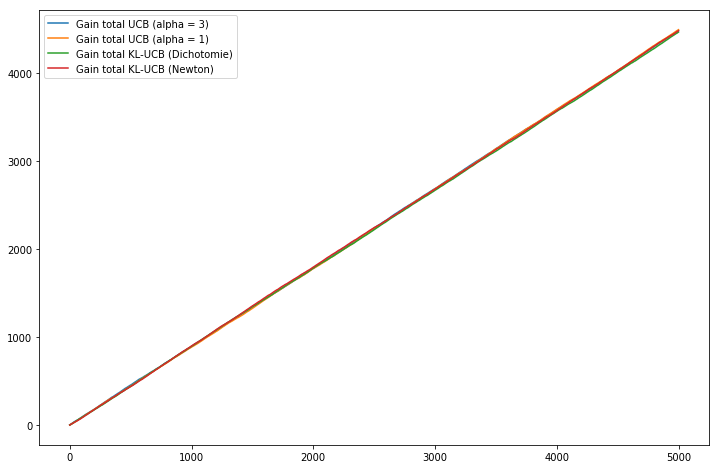

In [10]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

run = random.choice(range(runs))
print('Run n°', run)
ax1.plot(total_rewards_list_ucb3[run,:],linestyle='-',label='Gain total UCB (alpha = 3)')
ax1.plot(total_rewards_list_ucb1[run,:],linestyle='-',label='Gain total UCB (alpha = 1)')
ax1.plot(total_rewards_list_klucb_dichotomie[run,:],linestyle='-',label='Gain total KL-UCB (Dichotomie)')
ax1.plot(total_rewards_list_klucb_newton[run,:],linestyle='-',label='Gain total KL-UCB (Newton)')
ax1.legend(loc='best')
plt.show()

### Gain moyen total des différents algorithmes

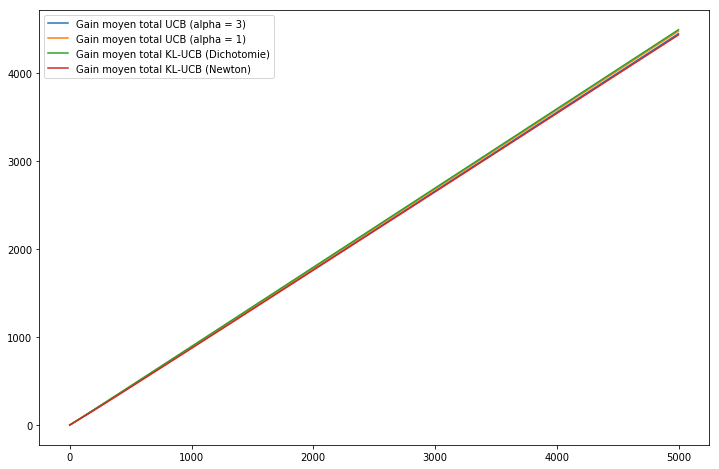

In [11]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(mean_total_rewards_list_ucb3[:],linestyle='-',label='Gain moyen total UCB (alpha = 3)')
ax1.plot(mean_total_rewards_list_ucb1[:],linestyle='-',label='Gain moyen total UCB (alpha = 1)')
ax1.plot(mean_total_rewards_list_klucb_dichotomie[:],linestyle='-',label='Gain moyen total KL-UCB (Dichotomie)')
ax1.plot(mean_total_rewards_list_klucb_newton[:],linestyle='-',label='Gain moyen total KL-UCB (Newton)')
ax1.legend(loc='best')
plt.show()

### Evolution moyenne du Pseudo-Regret en fonction de t

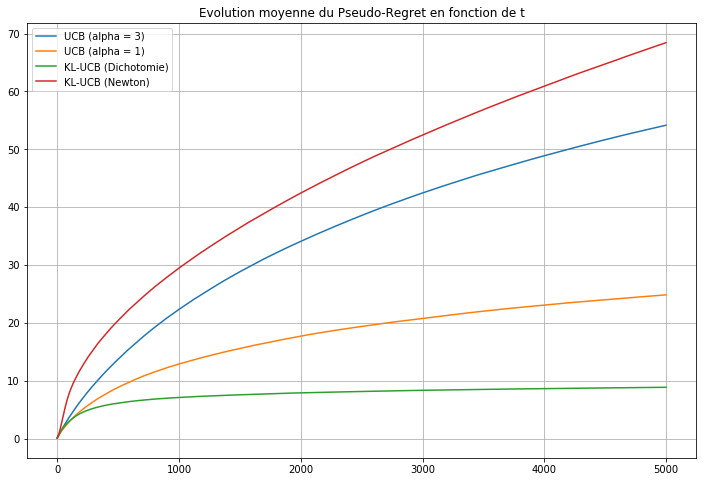

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

ax.plot(np.cumsum(mean_sub_arm_ucb3)*delta[0], linestyle='-', label='UCB (alpha = 3)')
ax.plot(np.cumsum(mean_sub_arm_ucb1)*delta[0], linestyle='-', label='UCB (alpha = 1)')
ax.plot(np.cumsum(mean_sub_arm_klucb_dichotomie)*delta[0], linestyle='-', label='KL-UCB (Dichotomie)')
ax.plot(np.cumsum(mean_sub_arm_klucb_newton)*delta[0], linestyle='-', label='KL-UCB (Newton)')

ax.grid(True)
ax.legend(loc='best')
ax.set_title('Evolution moyenne du Pseudo-Regret en fonction de t')
#plt.xlim( 10**2, 2*10**4 ) 
plt.show()

### Boxplot de distribution du Pseudo-Regret à $t = 5000$

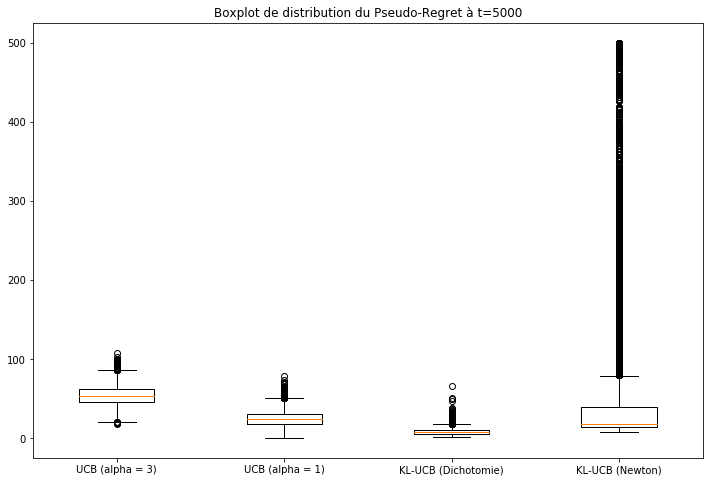

In [13]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        sub_arm_draws_T_ucb3*delta[0], 
        sub_arm_draws_T_ucb1*delta[0], 
        sub_arm_draws_T_klucb_dichotomie*delta[0],
        sub_arm_draws_T_klucb_newton*delta[0]
    ])
ax.set_xticklabels(['UCB (alpha = 3)', 'UCB (alpha = 1)', 'KL-UCB (Dichotomie)', 'KL-UCB (Newton)'])
ax.set_title('Boxplot de distribution du Pseudo-Regret à t='+str(T))
plt.show()

## Enregistrer les données